In [37]:
import psycopg2
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Apertura de la base de datos

In [38]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

In [39]:
cur.execute("SELECT nfft, espectro, frec_central, frec_muestreo FROM radioastronomia_espectro WHERE (frec_central = 94000000 AND nfft=1024)")
rows = cur.fetchall()


In [40]:
nfft = rows[0][0]
espectro = rows[0][1]
frec_central = rows[0][2]
frec_muestreo = rows[0][3]

In [41]:
def promedio(espectro, nfft):
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x

1024


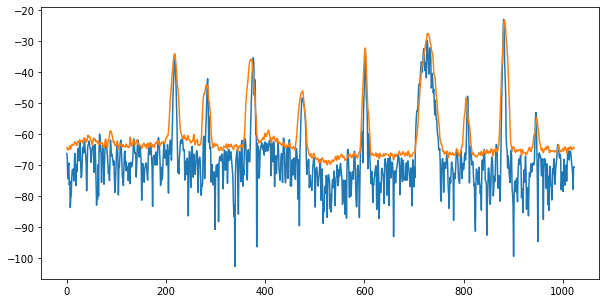

In [42]:
x = promedio(espectro, nfft)
plt.figure(figsize=(10,5))
plt.plot(espectro[0:nfft])
plt.plot(x)
print(nfft)

In [43]:
s = espectro[0:nfft]
for i in range(int(len(espectro)/nfft)-1):
    s = numpy.vstack((s, espectro[nfft*(i+1):nfft*(i+2)]))

In [44]:
df1 = pd.DataFrame(data=espectro)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59392 entries, 0 to 59391
Data columns (total 1 columns):
0    59392 non-null float64
dtypes: float64(1)
memory usage: 464.1 KB


## querys para extraer barrido

seleccion de las frecuencias de muestreo, las frecuencias centrales
y el tamaño de la FFT, esto es para que el espectro seleccionado tenga las 
mismas características


In [45]:
cur.execute("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
rows = cur.fetchall()
frec_central = []
for row in rows:
    frec_central.append(row[0])

cur.execute("SELECT DISTINCT frec_muestreo FROM radioastronomia_espectro;")
rows = cur.fetchall()
frec_muestreo = []
for row in rows:
    print(row)
    frec_muestreo.append(row[0])

cur.execute("SELECT DISTINCT nfft FROM radioastronomia_espectro;")
rows = cur.fetchall()
nfft = []
for row in rows:
    nfft.append(row[0])

print("frecuencia muestreo {}".format(frec_muestreo))
print("frecuencia central {}".format(frec_central))
print("tamano FFT {}".format(nfft))

(1000000,)
(2000000,)
(8000000,)
(16000000,)
frecuencia muestreo [1000000, 2000000, 8000000, 16000000]
frecuencia central [71000000.0, 72000000.0, 73000000.0, 74000000.0, 75000000.0, 76000000.0, 77000000.0, 78000000.0, 79000000.0, 80000000.0, 80500000.0, 81000000.0, 81500000.0, 82000000.0, 82500000.0, 83000000.0, 83500000.0, 84000000.0, 84500000.0, 85000000.0, 85500000.0, 86000000.0, 86500000.0, 87000000.0, 87500000.0, 88000000.0, 88500000.0, 89000000.0, 89500000.0, 90000000.0, 91000000.0, 92000000.0, 93000000.0, 94000000.0, 96000000.0, 98000000.0, 102000000.0, 110000000.0, 118000000.0, 126000000.0, 134000000.0, 142000000.0, 150000000.0, 158000000.0, 166000000.0, 174000000.0, 182000000.0, 190000000.0, 198000000.0, 408000000.0, 416000000.0, 424000000.0, 432000000.0, 440000000.0, 448000000.0, 456000000.0, 464000000.0, 472000000.0, 475000000.0, 480000000.0, 488000000.0, 496000000.0]
tamano FFT [1024]


## seleccion de los tamaños de FFT

# Este es el generador de querys principal para crear el reporte

In [46]:
""" Esto hace un barrido de frecuencias """
df = pd.DataFrame(data=numpy.zeros(1024), columns=["X0"])
y = numpy.array([])
for frec_cen in frec_central:
    query = []
    query.append("SELECT espectro FROM radioastronomia_espectro ")
    query.append("WHERE (nfft = ")
    query.append(str(1024))
    query.append(" AND frec_muestreo = ")
    query.append(str(8000000))
    query.append(" AND frec_central = ")
    query.append(str(frec_cen))
    query.append(");")
    query = "".join(query)
    print(query)
            
    # extraccion del espectro
    cur.execute(query)
    rows = cur.fetchall()
    x_ = numpy.zeros(1024)
    for row in rows:
        espectro = row[0]
        espectro = numpy.asarray(espectro)
        x = promedio(espectro, 1024)
        x_ = x_ + x
    x_ = x_/len(rows)
    df[str(frec_cen)]=x_
    y = numpy.append(y, x_)
df = df.drop("X0", axis=1)

SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 71000000.0);


/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 72000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 73000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 74000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 75000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 76000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 77000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 78000000.0);
SELECT espectro FROM radioastronomia_espectro WHERE (nfft = 1024 AND frec_muestreo = 8000000 AND frec_central = 79000000.0);


In [47]:
df.head()

,71000000.0,72000000.0,73000000.0,74000000.0,75000000.0,76000000.0,77000000.0,78000000.0,79000000.0,80000000.0,...,432000000.0,440000000.0,448000000.0,456000000.0,464000000.0,472000000.0,475000000.0,480000000.0,488000000.0,496000000.0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-63.023218,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-63.147307,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-63.327208,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-63.956654,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-64.881015,NaN,NaN,NaN


In [48]:
df.info()
f = numpy.linspace(78, 118, len(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 62 columns):
71000000.0     0 non-null float64
72000000.0     0 non-null float64
73000000.0     0 non-null float64
74000000.0     0 non-null float64
75000000.0     0 non-null float64
76000000.0     0 non-null float64
77000000.0     0 non-null float64
78000000.0     0 non-null float64
79000000.0     0 non-null float64
80000000.0     0 non-null float64
80500000.0     0 non-null float64
81000000.0     0 non-null float64
81500000.0     0 non-null float64
82000000.0     1024 non-null float64
82500000.0     0 non-null float64
83000000.0     0 non-null float64
83500000.0     0 non-null float64
84000000.0     0 non-null float64
84500000.0     0 non-null float64
85000000.0     0 non-null float64
85500000.0     0 non-null float64
86000000.0     1024 non-null float64
86500000.0     0 non-null float64
87000000.0     0 non-null float64
87500000.0     0 non-null float64
88000000.0     0 non-null float64
885

Text(0, 0.5, 'Espectro')

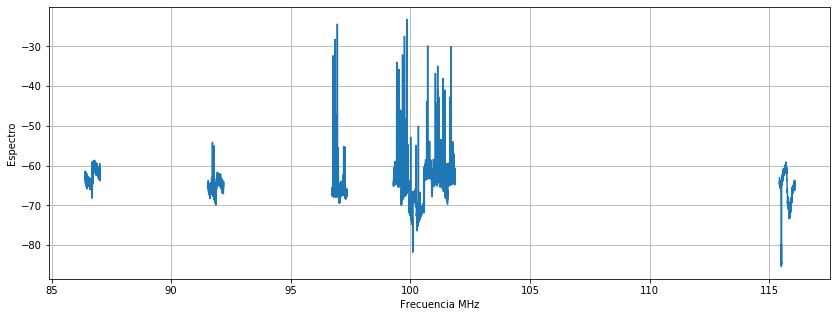

In [49]:
plt.figure(figsize=(14,5))
plt.plot(f, y)
plt.grid(True)
plt.xlabel("Frecuencia MHz")
plt.ylabel("Espectro")

## Analisis de las caracteristicas

In [50]:
query = "SELECT * FROM radioastronomia_caracteristicasespectro WHERE (id=6);"
cur.execute(query)
rows = cur.fetchall()

In [51]:
id = rows[0][0]
max_v = rows[0][1]
max_v = numpy.asarray(max_v)
min_v = rows[0][2]
min_v = numpy.asarray(min_v)
energia = rows[0][4]
energia = numpy.asarray(energia)
df = pd.DataFrame(data=numpy.array([10*numpy.log10(energia), min_v, max_v]).T, columns=["ener_", "min_", "max_"])

IndexError: list index out of range

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
sns.pairplot(df)

In [ ]:
#sns.distplot(df["ener_"])
sns.distplot(df["max_"], label="max")
sns.distplot(df["min_"], label="min")
plt.grid(True)
plt.legend()